In [1]:
from pathlib import Path
from multiprocessing import Pool
from pandas import DataFrame, read_excel, to_datetime
from matplotlib import font_manager, pyplot as plt

In [2]:
root = Path("../data/ข้อมูลน้ำ 58-63/").resolve()

In [3]:
def iter_files():
    for path in filter(lambda path: path.is_dir(), root.iterdir()):
        for station in filter(lambda path: path.is_dir(), path.iterdir()):
            for file in filter(lambda file: file.is_file() and file.suffix == ".xls", station.iterdir()):
                yield (f"{path.name} {station.name}", str(file))

In [4]:
month = {x: y for x, y in zip("ม.ค. ก.พ. มี.ค. เม.ย. พ.ค. มิ.ย. ก.ค. ส.ค. ก.ย. ต.ค. พ.ย. ธ.ค.".split(), range(1, 13))}

def task(args: tuple[str, str]):
    station, file = args
    df = read_excel(file)
    ok = 0
    miss = 0
    tmp = []
    for _, row in df.iterrows():
        is_ok = all(map(lambda k: (k in row) and (str(row[k]).strip() not in ("", "-")), ("วันที่-เวลา", "pH", "DO", "EC", "Temp")))
        if is_ok:
            ok += 1
            day, month_year, _time = row["วันที่-เวลา"].split(" ")
            _time = _time.split(":")
            date_time = to_datetime(f"{int(month_year[-4:]) - 543}-{month[month_year[:-4]]}-{day} {_time[0]}:{_time[1]}")
            tmp.append((date_time, row["pH"], row["EC"], row["Temp"], row["DO"]))
        else:
            miss += 1
    return (station, ok, miss, tmp)

In [5]:
with Pool() as pool:
	result = pool.map(task, iter_files())

In [6]:
data = {}
for file in result:
    station = data[file[0]] if file[0] in data else [file[0], 0, 0, []]
    for i in range(1, 4): station[i] += file[i]
    data[file[0]] = station

In [7]:
for station in data.values():
    df = DataFrame({
        "Datetime": (x[0] for x in station[3]),
        "pH": (x[1] for x in station[3]),
        "EC": (x[2] for x in station[3]),
        "Temp": (x[3] for x in station[3]),
        "DO": (x[4] for x in station[3])
    })
    count = len(df)
    df = df.sort_values(by="Datetime")
    df = df.drop_duplicates()
    station.append(count - len(df))
    df.to_csv(f"../output/{station[0]}.csv", index=False)

In [8]:
stations = data.values()
df_out = DataFrame({
    "Station": (x[0] for x in stations),
    "Total": (x[1] + x[2] for x in stations),
    "OK": (x[1] - x[4] for x in stations),
    "Duplicate": (x[4] for x in stations)
})
df_out = df_out.sort_values(by="OK", ascending=False)
print(df_out)
df_out.to_csv("../output/output.csv", index=False)

                              Station  Total     OK  Duplicate
18            น่าน พิษณุโลก 2558-2563  88265  79409        731
8       แม่น้ำท่าจีน บางเลน 2558-2563  98746  77955         51
0      ป่าสัก3สถานี นครหลวง 2558-2563  85184  75027        101
4                ยม สามง่าม 2558-2563  77859  73980         49
12  แม่น้ำท่าจีน สุพรรณบุรี 2558-2563  77994  69464         57
1      ป่าสัก3สถานี แก่งคอย 2558-2563  92688  69071        161
2       ป่าสัก3สถานี เสาไห้ 2558-2563  70819  68334        142
16           น่าน อุตรดิตถ์ 2558-2563  96165  67040         50
9   แม่น้ำท่าจีน สองพี่น้อง 2558-2563  74837  65464       2726
17                น่าน น่าน 2558-2563  94835  62556         58
15            ปิง กำแพงเพชร 2558-2563  82788  61887         67
14            ปิง เชียงใหม่ 2558-2563  83708  55988        124
6                วัง เกาะคา 2558-2563  95369  54627      15444
11       แม่น้ำท่าจีน หันคา 2558-2563  72458  52414         27
7   แม่น้ำท่าจีน กระทุ่มแบน 2558-2563  71976  49794    

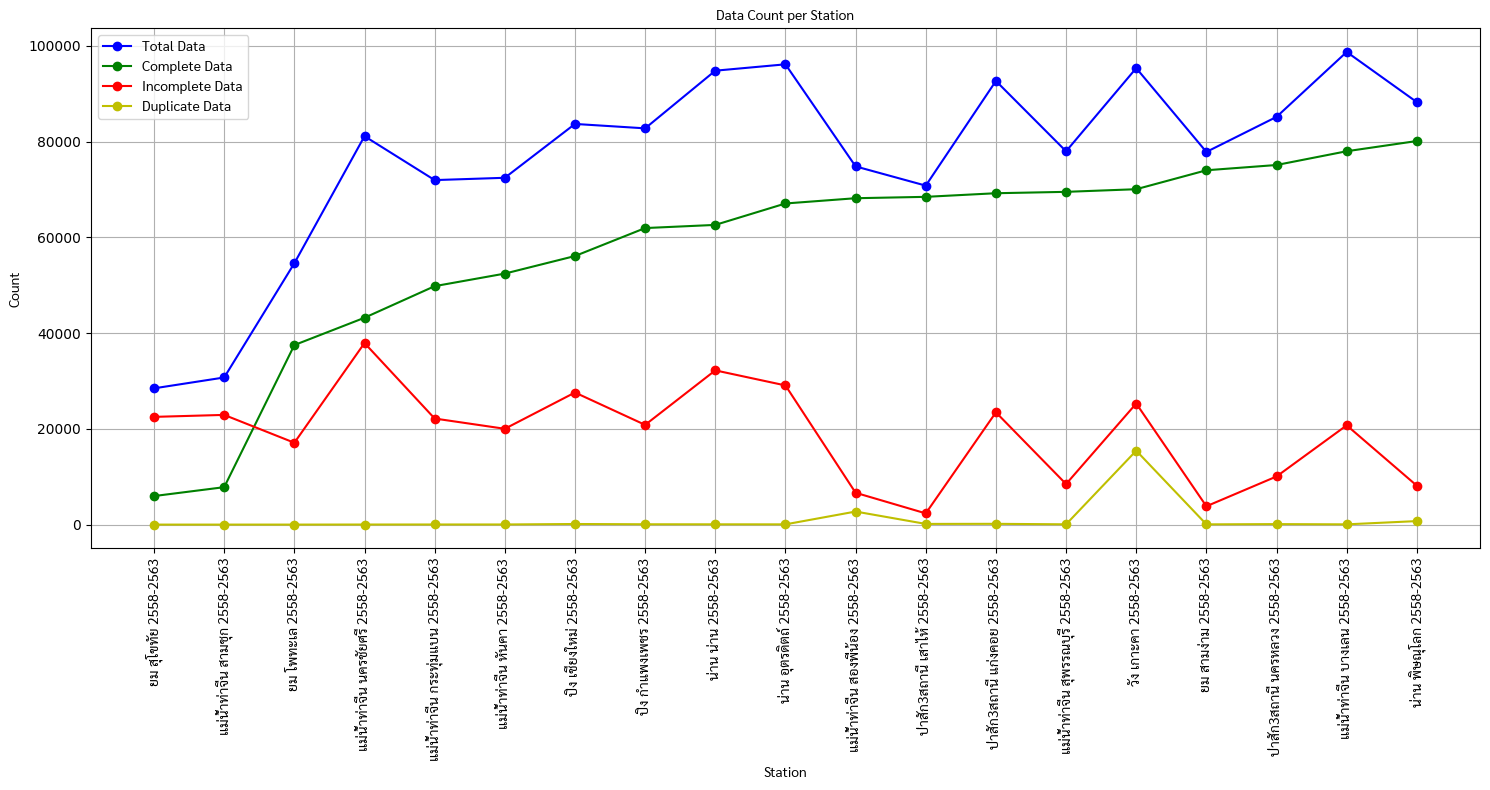

In [9]:
data_list = sorted(list(data.values()), key=lambda x: x[1])
font_prop = font_manager.FontProperties(fname="../submodules/sarabun-font/fonts/Sarabun-Regular.ttf")
stations = [item[0] for item in data_list]
ok_counts = [item[1] for item in data_list]
missing_counts = [item[2] for item in data_list]
total_counts = [ok + missing for ok, missing in zip(ok_counts, missing_counts)]
duplicate_counts = [item[4] for item in data_list]

plt.figure(figsize=(15, 8))
plt.plot(stations, total_counts, label="Total Data", marker="o", color="b")
plt.plot(stations, ok_counts, label="Complete Data", marker="o", color="g")
plt.plot(stations, missing_counts, label="Incomplete Data", marker="o", color="r")
plt.plot(stations, duplicate_counts, label="Duplicate Data", marker="o", color="y")
plt.xlabel("Station", fontproperties=font_prop)
plt.ylabel("Count", fontproperties=font_prop)
plt.title("Data Count per Station", fontproperties=font_prop)
plt.xticks(rotation=90, fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True)
plt.tight_layout()
plt.savefig("../output/plot.png")
plt.show()